In [1]:
import os
import re
import cv2
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Road Detection using OpenCV')

Read Video Frames

In [11]:
# get file names of frames
col_frames = os.listdir('frames/')
col_frames.sort(key=lambda f: int(re.sub('\D', '', f)))

# load frames
col_images=[]
for i in tqdm_notebook(col_frames):
    img = cv2.imread('frames/'+i)
    col_images.append(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Let’s plot one of the frames:

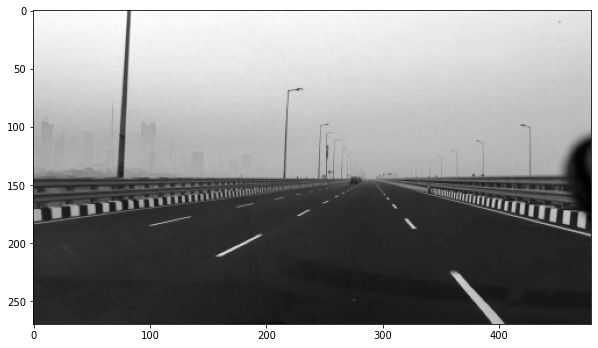

In [12]:
# specify frame index
idx = 457

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(col_images[idx][:,:,0], cmap= "gray")
plt.show()

Frame Mask Creation

Our region of interest is in the shape of a polygon. We want to mask everything except this region. Therefore, we first have to specify the coordinates of the polygon and then use it to prepare the frame mask:

In [13]:

# create a zero array
stencil = np.zeros_like(col_images[idx][:,:,0])

# specify coordinates of the polygon
polygon = np.array([[50,270], [220,160], [360,160], [480,270]])

# fill polygon with ones
cv2.fillConvexPoly(stencil, polygon, 1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

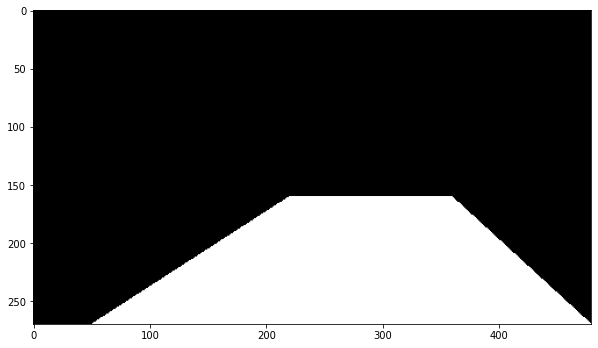

In [14]:
# plot polygon
plt.figure(figsize=(10,10))
plt.imshow(stencil, cmap= "gray")
plt.show()

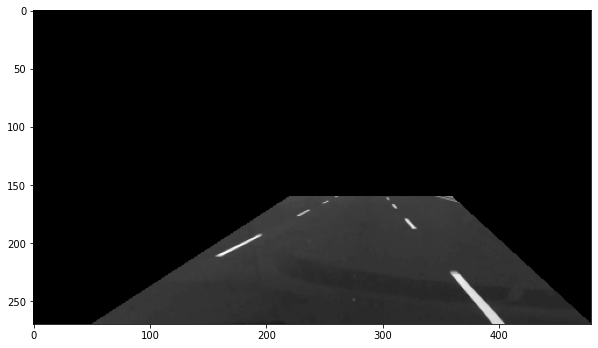

In [15]:
# apply polygon as a mask on the frame
img = cv2.bitwise_and(col_images[idx][:,:,0], col_images[idx][:,:,0], mask=stencil)

# plot masked frame
plt.figure(figsize=(10,10))
plt.imshow(img, cmap= "gray")
plt.show()

#Image Pre-processing



We have to perform a couple of image pre-processing operations on the video frames to detect the desired lane. The pre-processing operations are:

Image Thresholding
Hough Line Transformation

1. Image Thresholding

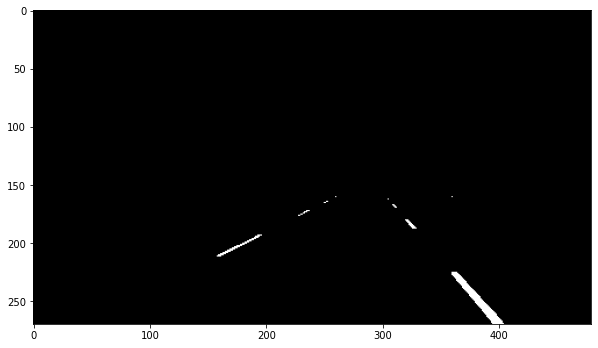

In [16]:
# apply image thresholding
ret, thresh = cv2.threshold(img, 130, 145, cv2.THRESH_BINARY)

# plot image
plt.figure(figsize=(10,10))
plt.imshow(thresh, cmap= "gray")
plt.show()

2. Hough Line Transformation

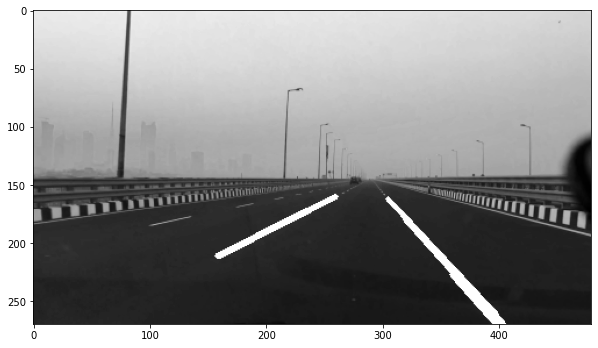

In [17]:
lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)

# create a copy of the original frame
dmy = col_images[idx][:,:,0].copy()

# draw Hough lines
for line in lines:
  x1, y1, x2, y2 = line[0]
  cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)

# plot frame
plt.figure(figsize=(10,10))
plt.imshow(dmy, cmap= "gray")
plt.show()

Now we will apply all these operations on each and every frame. We will also save the resultant frames in a new directory:

In [43]:

cnt = 0

for img in tqdm_notebook(col_images):
  
  # apply frame mask
  masked = cv2.bitwise_and(img[:,:,0], img[:,:,0], mask=stencil)
  
  # apply image thresholding
  ret, thresh = cv2.threshold(masked, 130, 145, cv2.THRESH_BINARY)

  # apply Hough Line Transformation
  lines = cv2.HoughLinesP(thresh, 1, np.pi/180, 30, maxLineGap=200)
  dmy = img.copy()
  
  # Plot detected lines
  try:
    for line in lines:
      x1, y1, x2, y2 = line[0]
      cv2.line(dmy, (x1, y1), (x2, y2), (255, 0, 0), 3)
  
    cv2.imwrite('detected/'+str(cnt)+'.png',dmy)
  
  except TypeError: 
    cv2.imwrite('detected/'+str(cnt)+'.png',img)

  cnt+= 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


#Video Preparation

In [44]:
# input frames path
pathIn= 'detected/'

# output path to save the video
pathOut = 'roads_v2.mp4'

# specify frames per second
fps = 30.0

In [45]:
from os.path import isfile, join

# get file names of the frames
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
files.sort(key=lambda f: int(re.sub('\D', '', f)))

Next, we will get all the frames with the detected lane into a list:

In [47]:
frame_list = []
for i in tqdm_notebook(range(len(files))):

  filename=pathIn + files[i]
  #reading each files
  img = cv2.imread(filename)
  height, width, layers = img.shape
  size = (width,height)
    
  #inserting the frames into an image array
  frame_list.append(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Finally, we can now combine the frames into a video by using the code below:

In [49]:

# write the video
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(frame_list)):
    # writing to a image array
    out.write(frame_list[i])

out.release()